In [1]:
from pymongo import MongoClient
import pandas as pd
import json
from pathlib import Path

def conectar_mongodb():
    client = MongoClient("mongodb://127.0.0.1:27017/")
    db = client['statistics_futebol']
    return db['futebol']

def carregar_csv():
    datasets = {
        'cartoes': pd.read_csv('csv/campeonato-brasileiro-cartoes.csv'),
        'estatisticas': pd.read_csv('csv/campeonato-brasileiro-estatisticas-full.csv'),
        'brasileirao': pd.read_csv('csv/campeonato-brasileiro-full.csv'),
        'gols': pd.read_csv('csv/campeonato-brasileiro-gols.csv')
    }
    return datasets

def carregar_json():
    dados_json = {}
    for ano in range(2003, 2024):  # Atualizando para incluir todos os anos até 2023
        try:
            arquivo = f'data/brasileirao-{ano}.json'
            with open(arquivo, 'r', encoding='utf-8') as f:
                dados_json[ano] = json.load(f)
        except FileNotFoundError:
            print(f"Arquivo do ano {ano} não encontrado")
    return dados_json

def inserir_dados(collection, datasets, dados_json):
    # Limpa a coleção antes de inserir novos dados
    collection.delete_many({})
    
    # Inserindo dados CSV
    for nome, df in datasets.items():
        documentos = df.to_dict('records')
        for doc in documentos:
            doc['tipo'] = nome  # Adiciona um campo para identificar o tipo de dado
        collection.insert_many(documentos)
    
    # Inserindo dados JSON
    for ano, dados in dados_json.items():
        collection.insert_one({
            'tipo': 'json',
            'ano': ano,
            'dados': dados
        })

def main():
    # Conectar ao MongoDB
    collection = conectar_mongodb()
    
    # Carregar dados
    datasets = carregar_csv()
    dados_json = carregar_json()
    
    # Inserir dados
    inserir_dados(collection, datasets, dados_json)
    
    # Verificar inserção
    total_documentos = collection.count_documents({})
    print(f"Total de documentos inseridos: {total_documentos}")
    
    # Mostrar contagem por tipo
    for tipo in ['cartoes', 'estatisticas', 'brasileirao', 'gols', 'json']:
        count = collection.count_documents({'tipo': tipo})
        print(f"Documentos do tipo {tipo}: {count}")

if __name__ == "__main__":
    main()

Total de documentos inseridos: 53025
Documentos do tipo cartoes: 18857
Documentos do tipo estatisticas: 16810
Documentos do tipo brasileirao: 8405
Documentos do tipo gols: 8932
Documentos do tipo json: 21


In [7]:
from pymongo import MongoClient
import pandas as pd

# Conexão com MongoDB
client = MongoClient("mongodb://127.0.0.1:27017/")
db = client['statistics_futebol']
collection = db['futebol']

# Buscar estatísticas
estatisticas = collection.find({'tipo': 'estatisticas'})

# Converter para DataFrame
df_estatisticas = pd.DataFrame(list(estatisticas))

# Remover o campo _id e tipo
if '_id' in df_estatisticas.columns:
    df_estatisticas = df_estatisticas.drop(['_id', 'tipo'], axis=1)

# Mostrar informações do DataFrame
print("Formato do DataFrame:", df_estatisticas.shape)
print("\nColunas disponíveis:")
print(df_estatisticas.columns.tolist())
print("\nPrimeiras 5 linhas:")
print(df_estatisticas.head())
print("\nResumo estatístico:")
print(df_estatisticas.describe())

Formato do DataFrame: (16810, 13)

Colunas disponíveis:
['partida_id', 'rodata', 'clube', 'chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'faltas', 'cartao_amarelo', 'cartao_vermelho', 'impedimentos', 'escanteios']

Primeiras 5 linhas:
   partida_id  rodata         clube  chutes  chutes_no_alvo posse_de_bola  \
0           1       1       Guarani       0               0           NaN   
1           1       1         Vasco       0               0           NaN   
2           2       1        Gremio       0               0           NaN   
3           2       1  Athletico-PR       0               0           NaN   
4           3       1      Coritiba       0               0           NaN   

   passes precisao_passes  faltas  cartao_amarelo  cartao_vermelho  \
0       0             NaN       0               0                0   
1       0             NaN       0               0                0   
2       0             NaN       0               0                

In [9]:
from pymongo import MongoClient
import pandas as pd

# Conexão MongoDB
client = MongoClient("mongodb://127.0.0.1:27017/")
db = client['statistics_futebol']
collection = db['futebol']

# Buscar dados do Brasileirão
brasileirao = collection.find({'tipo': 'brasileirao'})
df_brasileirao = pd.DataFrame(list(brasileirao))

# Remover campos _id e tipo se existirem
for campo in ['_id', 'tipo']:
    if campo in df_brasileirao.columns:
        df_brasileirao = df_brasileirao.drop(campo, axis=1)

# Converter a coluna 'data' (se existir) para datetime, informando dayfirst=True
if 'data' in df_brasileirao.columns:
    df_brasileirao['data'] = pd.to_datetime(df_brasileirao['data'], dayfirst=True)
    df_brasileirao = df_brasileirao.sort_values('data')

# Exibir informações
print("Dimensões do DataFrame:", df_brasileirao.shape)
print("\nColunas disponíveis:")
print(df_brasileirao.columns.tolist())
print("\nPrimeiros jogos:")
print(df_brasileirao.head())
print("\nEstatísticas gerais:")
print(df_brasileirao.describe())

# Contagem de jogos por temporada se a coluna existir
if 'temporada' in df_brasileirao.columns:
    print("\nJogos por temporada:")
    print(df_brasileirao['temporada'].value_counts().sort_index())
else:
    print("\nA coluna 'temporada' não foi encontrada no dataset.")

Dimensões do DataFrame: (8405, 16)

Colunas disponíveis:
['ID', 'rodata', 'data', 'hora', 'mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'tecnico_mandante', 'tecnico_visitante', 'vencedor', 'arena', 'mandante_Placar', 'visitante_Placar', 'mandante_Estado', 'visitante_Estado']

Primeiros jogos:
    ID  rodata       data   hora      mandante    visitante formacao_mandante  \
0    1       1 2003-03-29  16:00       Guarani        Vasco               NaN   
1    2       1 2003-03-29  16:00  Athletico-PR       Gremio               NaN   
11  12       1 2003-03-30  18:00   Corinthians  Atletico-MG               NaN   
10  11       1 2003-03-30  18:00        Santos       Parana               NaN   
8    9       1 2003-03-30  16:00      Cruzeiro  Sao Caetano               NaN   

   formacao_visitante tecnico_mandante tecnico_visitante      vencedor  \
0                 NaN              NaN               NaN       Guarani   
1                 NaN              NaN           

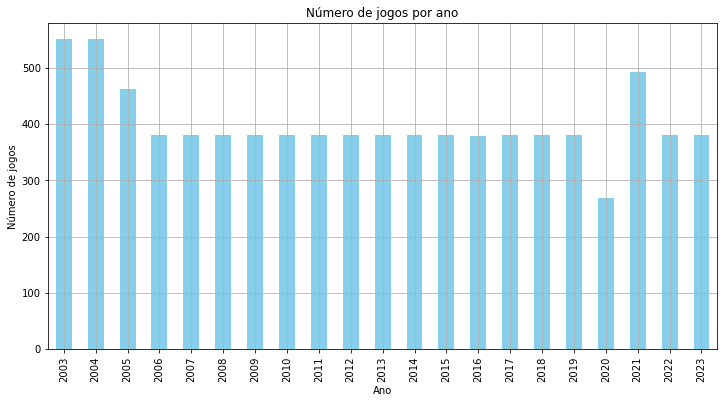

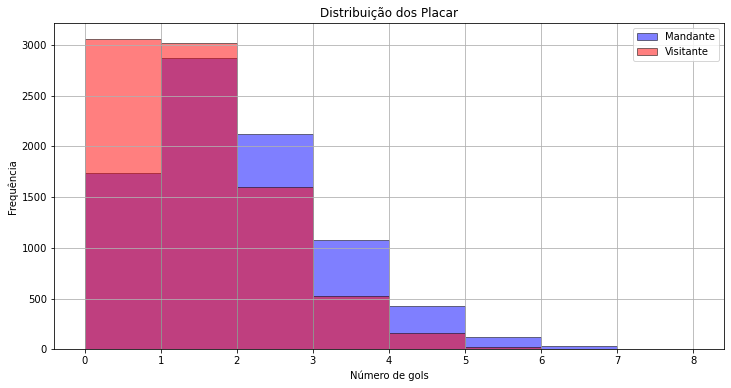

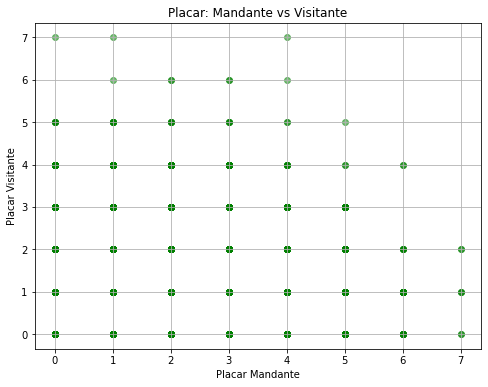

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

# Conectar ao MongoDB e carregar dados do Brasileirão
client = MongoClient("mongodb://127.0.0.1:27017/")
db = client['statistics_futebol']
collection = db['futebol']

# Buscar documentos do tipo 'brasileirao'
dados = collection.find({'tipo': 'brasileirao'})
df = pd.DataFrame(list(dados))

# Remover campos _id e tipo, se existirem
for coluna in ['_id', 'tipo']:
    if coluna in df.columns:
        df.drop(coluna, axis=1, inplace=True)

# Converter coluna 'data' para datetime
if 'data' in df.columns:
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    
# 1. Gráfico: Número de jogos por ano (extraindo ano da coluna 'data')
if 'data' in df.columns:
    df['ano'] = df['data'].dt.year
    jogos_por_ano = df['ano'].value_counts().sort_index()
    plt.figure(figsize=(12,6))
    jogos_por_ano.plot(kind='bar', color='skyblue')
    plt.title("Número de jogos por ano")
    plt.xlabel("Ano")
    plt.ylabel("Número de jogos")
    plt.grid(True)
    plt.show()

# 2. Gráfico: Distribuição dos placares de mandante e visitante
plt.figure(figsize=(12,6))
# Definindo bins de 0 a 8 gols
bins = range(0, 9)
plt.hist(df['mandante_Placar'], bins=bins, alpha=0.5, label='Mandante', color='blue', edgecolor='black')
plt.hist(df['visitante_Placar'], bins=bins, alpha=0.5, label='Visitante', color='red', edgecolor='black')
plt.title("Distribuição dos Placar")
plt.xlabel("Número de gols")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.show()

# 3. Gráfico: Scatter plot correlacionando placar do mandante vs visitante
plt.figure(figsize=(8,6))
plt.scatter(df['mandante_Placar'], df['visitante_Placar'], alpha=0.5, color='green')
plt.title("Placar: Mandante vs Visitante")
plt.xlabel("Placar Mandante")
plt.ylabel("Placar Visitante")
plt.grid(True)
plt.show()